In [1]:
%load_ext autoreload
%autoreload 2

import imageio
import torch
from text3d2video.diffusion import depth2img_pipe, depth2img
from text3d2video.rendering import normalize_depth_map, rasterize
from pathlib import Path
import torchvision.transforms as transforms
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from text3d2video.animation_artifact import AnimationArtifact
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import einsum, rearrange
from IPython import get_ipython
import torch
import wandb
import torchvision.transforms.functional as TF

/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [24]:
device = torch.device("cuda:0")

api = wandb.Api()

animation = 'backflip:latest'
animation = api.artifact(f'romeu/diffusion-3D-features/{animation}')
animation = AnimationArtifact.from_wandb_artifact(animation)

mesh = animation.load_static_mesh(device)

wandb: Downloading large artifact backflip:latest, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.7
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


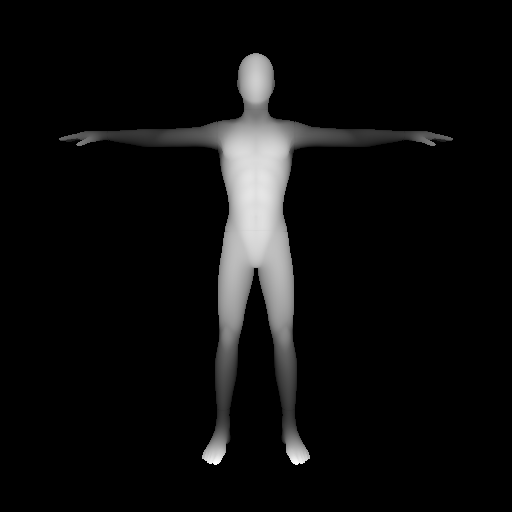

In [4]:
R, T = look_at_view_transform(dist=2, azim=0, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

res = 512
fragments, depth_map = rasterize(cameras, mesh, res)
depth_map_normalized = normalize_depth_map(depth_map).to(device)
depth_img = TF.to_pil_image(depth_map_normalized.cpu())
depth_img

In [5]:
pipe = depth2img_pipe()

Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:02,  2.19it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all publ

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 14.39it/s]


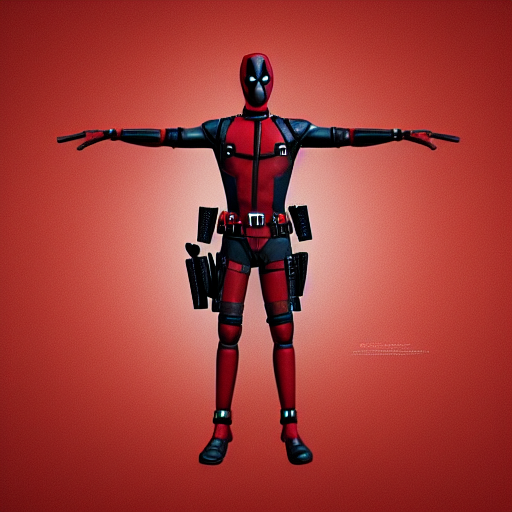

In [18]:
img_out = depth2img(pipe, ['Deadpool, blank background'], depth_img)
feature_map = TF.to_tensor(img_out[0])

img_out[0]

In [19]:
# %%
from text3d2video.util import project_vertices_to_features

vert_features = project_vertices_to_features(mesh, cameras, feature_map)

In [75]:
# Render projected features
from text3d2video.rendering import rasterize_vertex_features
from moviepy.editor import ImageSequenceClip

frames = []
feature_res = feature_map.shape[1]

n_frames = 40
duration_secs = 2
for frame_i in tqdm(animation.frame_nums(sample_n=n_frames)):
    mesh = animation.load_frame(frame_i)
    rendered_features = rasterize_vertex_features(cameras, mesh, feature_res, vert_features)
    frames.append(rendered_features.permute(1,2,0).cpu().numpy())


fps = n_frames / duration_secs
clip = ImageSequenceClip([f * 255 for f in frames], fps=fps)
clip.write_videofile('outs/backflip.mp4')
clip.write_gif('outs/backflip.gif', fps=fps)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Moviepy - Building video outs/backflip.mp4.
Moviepy - Writing video outs/backflip.mp4



Moviepy - Done !
Moviepy - video ready outs/backflip.mp4
MoviePy - Building file outs/backflip.gif with imageio.
